In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import random

shap.initjs()

In [2]:
# ============================
# 1. Load cleaned data
# ============================

data_path = "./data/processed/financial_report_bank_zscore_clean.csv"
df = pd.read_csv(data_path)

print("Shape data:", df.shape)
print(df.head())

Shape data: (1812, 27)
  symbol  calendar_year period    time       size       der       dar  \
0   AGRO           2023     Q4  2023Q4  30.151990  0.158755  0.043646   
1   AGRO           2023     Q3  2023Q3  30.067564  0.027119  0.008067   
2   AGRO           2023     Q2  2023Q2  30.116618  0.033987  0.009662   
3   AGRO           2023     Q1  2023Q1  30.168138  0.033731  0.009062   
4   AGRO           2022     Q4  2022Q4  30.262822  0.032612  0.007952   

        roa       roe      sdoa  ...  operating_income_ratio  quarter  \
0  0.000778  0.002830  0.000161  ...               -0.070020        4   
1  0.000472  0.001587  0.000052  ...                0.109110        3   
2  0.000408  0.001436  0.000891  ...                0.748114        2   
3  0.000346  0.001287  0.001173  ...                0.859516        1   
4 -0.001512 -0.006200  0.001532  ...                0.531961        4   

   equity_to_assets  roa_std_bank  bank_zscore  roa_count_bank  mask_bad  \
0          0.956354    

In [3]:
# ============================
# 2. Filter data tahun (tidak pakai 2024 yang incomplete)
# ============================
YEAR_START = 2014
YEAR_END   = 2023

df = df[df["calendar_year"].between(YEAR_START, YEAR_END)].copy()

if "symbol" in df.columns and "period" in df.columns:
    ok_pairs = (
        df.groupby(["symbol", "calendar_year"])["period"]
          .nunique()
          .reset_index(name="n_quarters")
          .query("n_quarters == 4")[["symbol", "calendar_year"]]
    )
    df = df.merge(ok_pairs, on=["symbol", "calendar_year"], how="inner")

# ============================
# 3. Pilih fitur & target
# ============================

feature_cols = [
    "size",
    "der", "dar",
    "roa", "roe",
    "sdoa", "sdroe",
    "tobinq",
    "ppe",
    "cash",
    "ar",
    "log_sales",
    "sgr",
    "operating_income_ratio",
    "equity_to_assets"
]

target_col = "bank_zscore_risk"

# Buang baris yang ada NaN di fitur/target
df_model = df.dropna(subset=feature_cols + [target_col]).copy()

X = df_model[feature_cols]
y = df_model[target_col].astype(int)

print("Data used years:", df_model["calendar_year"].min(), "-", df_model["calendar_year"].max())
print("Total rows:", len(df_model), "| Positive rate:", round(y.mean(), 4))

Data used years: 2014 - 2023
Total rows: 1812 | Positive rate: 0.2445


In [4]:
# Label per Horizon

MAX_HORIZON = 5

df_h = df_model.sort_values(["symbol", "calendar_year"]).copy()

for h in range(1, MAX_HORIZON + 1):
    df_h[f"distress_{h}y"] = (
        df_h.groupby("symbol")["bank_zscore_risk"]
            .shift(-h)
    )

df_h.head()

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk,distress_1y,distress_2y,distress_3y,distress_4y,distress_5y
36,AGRO,2014,Q4,2014Q4,29.485003,0.163192,0.035647,0.003419,0.024146,0.000710,...,40,False,52.412198,2.0,1,1.0,1.0,1.0,1.0,1.0
37,AGRO,2014,Q3,2014Q3,29.414072,0.163192,0.035647,0.001679,0.011505,0.000584,...,40,False,52.318001,2.0,1,1.0,1.0,1.0,1.0,1.0
38,AGRO,2014,Q2,2014Q2,29.370668,0.163192,0.035647,0.002572,0.017084,0.001346,...,40,False,52.366372,2.0,1,1.0,1.0,1.0,1.0,1.0
39,AGRO,2014,Q1,2014Q1,29.276297,0.163192,0.035647,0.003093,0.018537,0.002200,...,40,False,52.394569,2.0,1,1.0,1.0,1.0,1.0,1.0
32,AGRO,2015,Q4,2015Q4,29.755018,0.163192,0.035647,0.003282,0.020299,0.000690,...,40,False,52.404806,2.0,1,1.0,1.0,1.0,1.0,1.0


In [5]:
# ============================
# Performance Evaluation (Accuracy, AUC, PR-AUC, Confusion Matrix)
# ============================

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, accuracy_score,
    precision_recall_curve
)


def predict_best(booster, X):
    if isinstance(X, xgb.DMatrix):
        d = X
    else:
        d = xgb.DMatrix(X)
        
    try:
        return booster.predict(d, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        return booster.predict(d, ntree_limit=booster.best_ntree_limit)


def calc_type_errors(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    type1_error = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    type2_error = fp / (tn + fp) if (tn + fp) > 0 else np.nan

    return {
        "Type_I_error": type1_error,   # FAILED → predicted NON-FAILED
        "Type_II_error": type2_error,  # NON-FAILED → predicted FAILED
        "TP": tp, "FN": fn, "FP": fp, "TN": tn,
        "Recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan
    }


def eval_split(name, booster, X, y, thr=0.5):
    proba = predict_best(booster, X)
    pred = (proba >= thr).astype(int)

    auc = roc_auc_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    pr  = average_precision_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    acc = accuracy_score(y, pred)

    print(f"\n=== {name} (thr={thr}) ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC : {auc:.4f}")
    print(f"PR-AUC  : {pr:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print(classification_report(y, pred, digits=4))

    err = calc_type_errors(y, proba, thr)
    print(f"Type I Error : {err['Type_I_error']:.4f}")
    print(f"Type II Error: {err['Type_II_error']:.4f}")
    print(f"Recall: {err['Recall']:.4f}")

    return {
        "accuracy": acc,
        "roc_auc": auc,
        "pr_auc": pr,
        "type_I_error": err["Type_I_error"],
        "type_II_error": err["Type_II_error"],
        "recall": err["Recall"],
        "threshold": thr
    }


def build_threshold_table(y_true, proba):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)

    rows = []
    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()

        rows.append({
            "threshold": thr,
            "recall": tp / (tp + fn),
            "type_i_error": fn / (fn + tp),
            "type_ii_error": fp / (fp + tn),
            "precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan
        })

    return pd.DataFrame(rows)

    
# eval_split("VAL", booster, X_val, y_val, thr=0.5)
# eval_split("TEST", booster, X_test, y_test, thr=0.5)

In [6]:
def evaluate_xgb_model(model_dict, name=None):
    booster = model_dict["booster"]
    dtest   = model_dict["dtest"]
    y_test  = model_dict["y_test"]

    # HARDCODE TUNING TRESHOLD
    # thr     = model_dict["threshold"]
    thr     = 0.4

    name = name or f"TEST {model_dict['horizon']}Y"

    proba = predict_best(booster, dtest)
    pred  = (proba >= thr).astype(int)

    auc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)
    acc = accuracy_score(y_test, pred)

    print(f"\n=== {name} (thr={thr}) ===")
    print(f"Accuracy : {acc}")
    print(f"ROC-AUC  : {auc}")
    print(f"PR-AUC   : {pr}")
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))

    err = calc_type_errors(y_test, proba, thr)
    print(f"Type I Error : {err['Type_I_error']:.4f}")
    print(f"Type II Error: {err['Type_II_error']:.4f}")
    print(f"Recall      : {err['Recall']:.4f}")


def make_predict_fn(model, model_type, feature_cols=None):
    """
    Return f(X) -> probability of distress
    Compatible with XGB, RF, LGBM, NGBoost
    """

    if model_type == "xgb":
        def predict_fn(X):
            d = xgb.DMatrix(
                X,
                feature_names=feature_cols
            )
            return model.predict(d)

    elif model_type == "rf":
        def predict_fn(X):
            return model.predict_proba(X)[:, 1]

    elif model_type == "lgbm":
        def predict_fn(X):
            return model.predict(X)

    elif model_type == "ngboost":
        def predict_fn(X):
            return model.predict(X)   # Bernoulli → P(y=1)

    else:
        raise ValueError("model_type must be 'xgb', 'rf', 'lgbm', or 'ngboost'")

    return predict_fn


MODEL_TITLE_MAP = {
    "rf": "Random Forest",
    "xgb": "XGBoost",
    "lgbm": "LightGBM",
    "ngboost": "NGBoost"
}

SHAP_SAMPLE_N = 200
SHAP_BACKGROUND_N = 100
SHAP_RANDOM_STATE_EXPLAIN = 42
SHAP_RANDOM_STATE_BG = 1

def plot_shap_summary_for_horizon(
    model_dict, 
    feature_cols, 
    model_type="rf",   # "rf", "xgb", "lgbm", "ngboost"
    sample_n=SHAP_SAMPLE_N,
    background_n=SHAP_BACKGROUND_N,
    plot_type="dot"
):
    X_train = model_dict["X_train"]

    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=SHAP_RANDOM_STATE_EXPLAIN
    )

    if model_type == "xgb":
        booster = model_dict["booster"]
        dshap = xgb.DMatrix(X_sample)

        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(dshap)

    elif model_type in ["rf", "lgbm"]:
        model = model_dict["model"]
        explainer = shap.TreeExplainer(model)
        shap_values_raw = explainer.shap_values(X_sample)

        if isinstance(shap_values_raw, list):
            # multiclass / probabilistic output
            shap_values = shap_values_raw[1]  # class distress
        else:
            # already (n_samples, n_features)
            shap_values = shap_values_raw

    elif model_type == "ngboost":
        # ============================
        # Sampling
        # ============================
        X_bg = X_train.sample(
            n=min(background_n, len(X_train)),
            random_state=SHAP_RANDOM_STATE_BG
        )

        # ============================
        # KernelExplainer
        # ============================
        def predict_fn(X):
            # Bernoulli NGBoost → P(y=1)
            return model.pred_dist(X).p1
    
        explainer = shap.KernelExplainer(
            predict_fn,
            X_bg,
            link="logit"
        )
        shap_values = explainer.shap_values(X_sample)
        
    else:
        raise ValueError("model_type must be 'rf', 'xgb', 'ngboost', or 'lgbm'")

    # ============================
    # Safety check
    # ============================
    if not isinstance(shap_values, np.ndarray) or shap_values.ndim != 2:
        raise ValueError(
            f"SHAP values must be 2D array (n_samples, n_features), got {type(shap_values)} {getattr(shap_values, 'shape', None)}"
        )
    
    # shap_values[1] → class distress
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_cols,
        plot_type=plot_type,
        show=False
    )
    model_name = MODEL_TITLE_MAP.get(model_type, model_type.upper())
    plt.title(f"{model_name} SHAP Summary – {model_dict['horizon']}Y Horizon")
    plt.tight_layout()
    plt.show()

In [7]:
import xgboost as xgb

# Split Training and Validation year of data
TRAIN_END_YEAR = 2019
VAL_END_YEAR = 2021

def train_xgb_for_horizon(
    df,
    feature_cols,
    horizon,
    train_end_year,
    val_end_year,
    random_search_iter=20,
    recall_target=0.75
):
    print(f"\n===== TRAIN HORIZON {horizon}Y =====")

    df_hh = df.dropna(subset=[f"distress_{horizon}y"]).copy()

    y = df_hh[f"distress_{horizon}y"].astype(int)
    X = df_hh[feature_cols]

     # time-based split
    train_mask = df_hh["calendar_year"] <= TRAIN_END_YEAR
    val_mask   = (df_hh["calendar_year"] > TRAIN_END_YEAR) & \
                 (df_hh["calendar_year"] <= VAL_END_YEAR)
    test_mask  = df_hh["calendar_year"] > VAL_END_YEAR

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    # DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # == RANDOM SEARCH ==
    best = {"pr": -1}

    for _ in range(random_search_iter):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "tree_method": "hist",
            "seed": 42,
            "scale_pos_weight": scale_pos_weight,

            "eta": np.random.choice([0.01, 0.03, 0.05]),
            "max_depth": np.random.choice([3, 4, 5]),
            "min_child_weight": np.random.choice([1, 3]),
            "subsample": np.random.choice([0.8, 1.0]),
            "colsample_bytree": np.random.choice([0.6, 0.8]),
            "lambda": np.random.choice([0.5, 1.0]),
            "gamma": np.random.choice([0.0, 0.5]),
        }

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=3000,
            evals=[(dtrain, "train"), (dval, "val")],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        proba_val = predict_best(booster, dval)
        pr = average_precision_score(y_val, proba_val)

        if pr > best["pr"]:
            best = {
                "pr": pr,
                "params": params,
                "best_iter": booster.best_iteration
            }
    
    # == FINAL TRAIN ==
    booster = xgb.train(
        params=best["params"],
        dtrain=dtrain,
        num_boost_round=best["best_iter"] + 1,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    # == THRESHOLD TUNING ==
    proba_val = predict_best(booster, dval)
    thr_df = build_threshold_table(y_val, proba_val)
    chosen_thr = thr_df[thr_df["recall"] >= recall_target].iloc[-1]["threshold"]
    print("Chosen threshold:", chosen_thr)

    return {
        "horizon": horizon,
        "booster": booster,
        "threshold": chosen_thr,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "dtest": dtest
    }

In [8]:
# ============================
# Looping to Train All Horizon
# ============================

models = {}

for h in [1, 2, 3, 4, 5]:
    models[h] = train_xgb_for_horizon(
        df=df_h,
        feature_cols=feature_cols,
        horizon=h,
        train_end_year=TRAIN_END_YEAR,
        val_end_year=VAL_END_YEAR
    )


===== TRAIN HORIZON 1Y =====
Chosen threshold: 0.5096449255943298

===== TRAIN HORIZON 2Y =====
Chosen threshold: 0.475945383310318

===== TRAIN HORIZON 3Y =====
Chosen threshold: 0.5101144909858704

===== TRAIN HORIZON 4Y =====
Chosen threshold: 0.5199130773544312

===== TRAIN HORIZON 5Y =====
Chosen threshold: 0.5345451235771179


In [9]:
models

{1: {'horizon': 1,
  'booster': <xgboost.core.Booster at 0x7ffeca9eefd0>,
  'threshold': 0.5096449255943298,
  'X_train':            size       der       dar       roa       roe      sdoa     sdroe  \
  36    29.485003  0.163192  0.035647  0.003419  0.024146  0.000710  0.005172   
  37    29.414072  0.163192  0.035647  0.001679  0.011505  0.000584  0.003031   
  38    29.370668  0.163192  0.035647  0.002572  0.017084  0.001346  0.008377   
  39    29.276297  0.163192  0.035647  0.003093  0.018537  0.002200  0.012384   
  32    29.755018  0.163192  0.035647  0.003282  0.020299  0.000690  0.005316   
  ...         ...       ...       ...       ...       ...       ...       ...   
  1795  30.969818  0.362714  0.080535  0.005377  0.024216  0.000677  0.003221   
  1788  31.240215  1.157043  0.217260  0.002111  0.011244  0.000827  0.004737   
  1789  31.296269  1.247369  0.218797  0.003120  0.017785  0.000626  0.002238   
  1790  31.245035  1.339360  0.242862  0.004137  0.022815  0.000332  0


=== TEST 1Y (thr=0.4) ===
Accuracy : 0.8229813664596274
ROC-AUC  : 0.8994850777637663
PR-AUC   : 0.6996561964746971
Confusion matrix:
 [[215  29]
 [ 28  50]]
Type I Error : 0.3590
Type II Error: 0.1189
Recall      : 0.6410


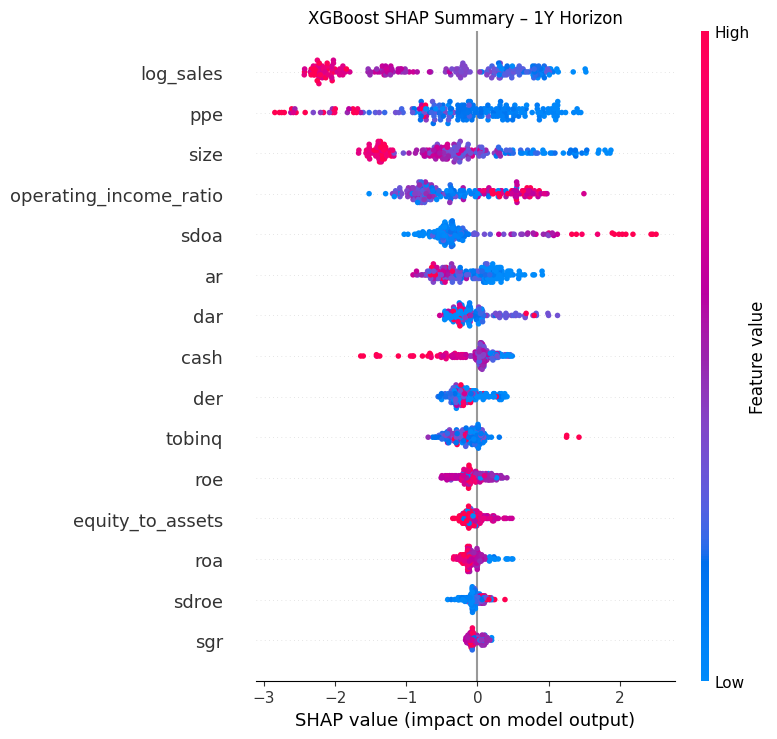


=== TEST 2Y (thr=0.4) ===
Accuracy : 0.8152173913043478
ROC-AUC  : 0.8974505463115047
PR-AUC   : 0.702534828805477
Confusion matrix:
 [[183  26]
 [ 25  42]]
Type I Error : 0.3731
Type II Error: 0.1244
Recall      : 0.6269


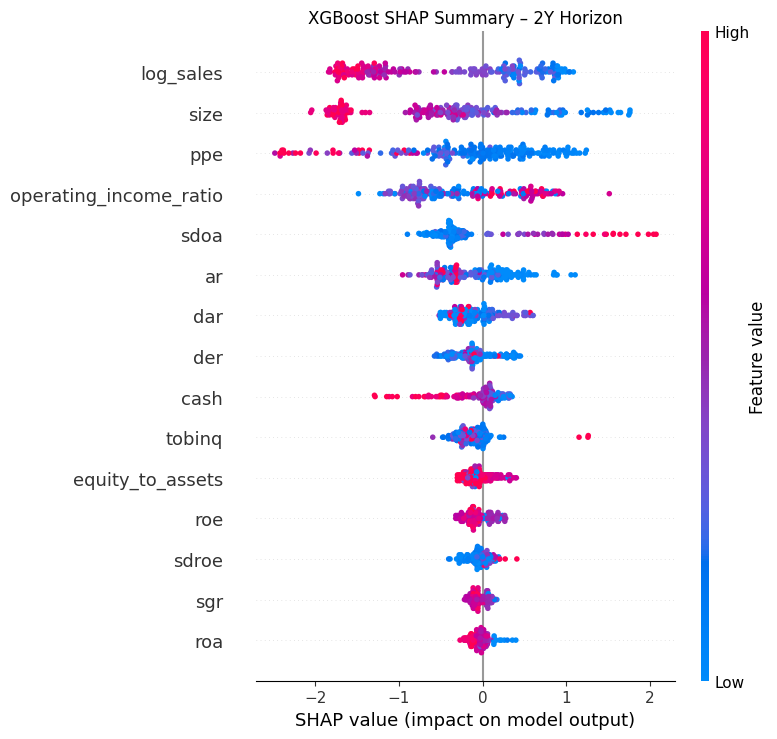


=== TEST 3Y (thr=0.4) ===
Accuracy : 0.8260869565217391
ROC-AUC  : 0.8947044334975369
PR-AUC   : 0.69393321535299
Confusion matrix:
 [[153  21]
 [ 19  37]]
Type I Error : 0.3393
Type II Error: 0.1207
Recall      : 0.6607


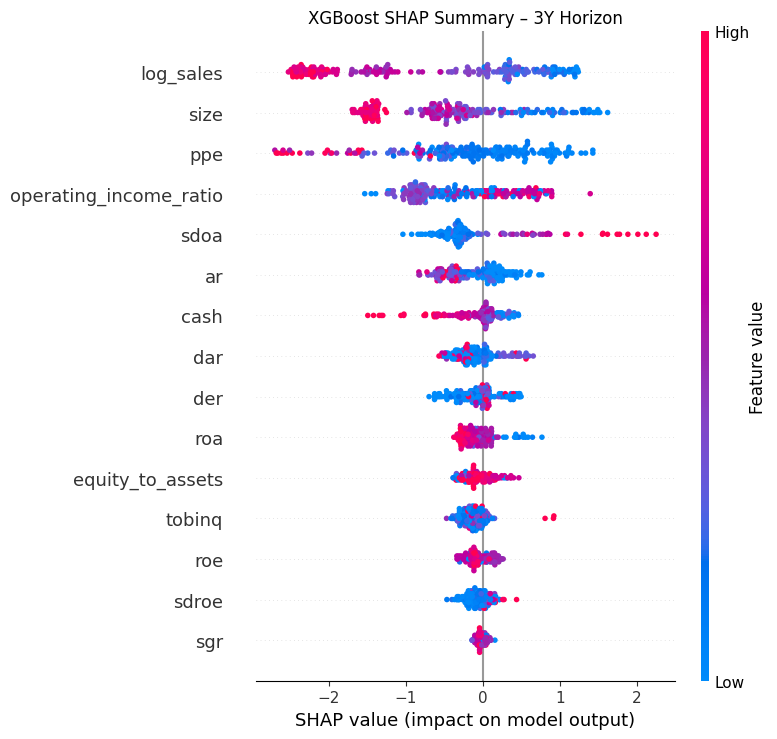


=== TEST 4Y (thr=0.4) ===
Accuracy : 0.8206521739130435
ROC-AUC  : 0.9112709832134293
PR-AUC   : 0.7595981990613143
Confusion matrix:
 [[119  20]
 [ 13  32]]
Type I Error : 0.2889
Type II Error: 0.1439
Recall      : 0.7111


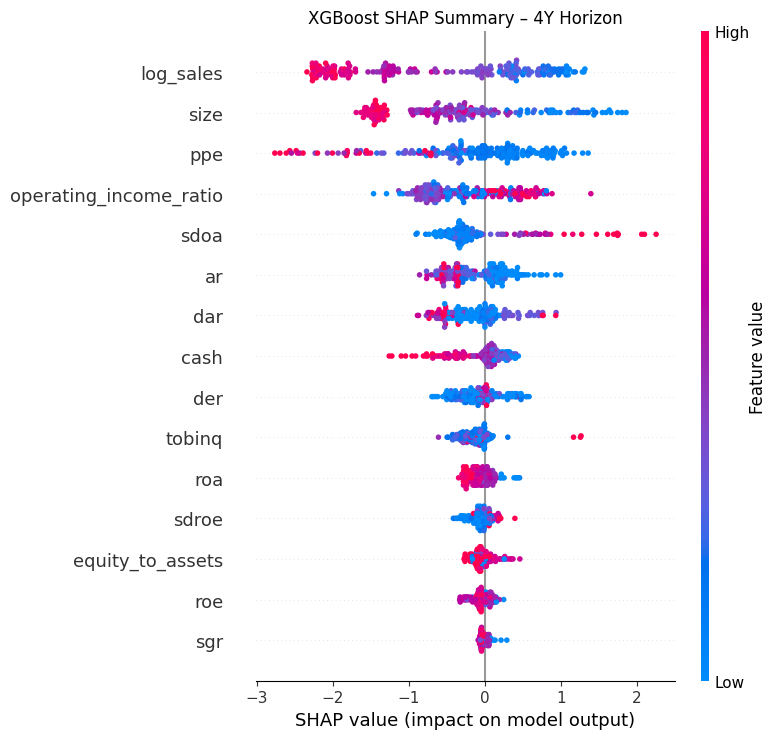


=== TEST 5Y (thr=0.4) ===
Accuracy : 0.7898550724637681
ROC-AUC  : 0.879524886877828
PR-AUC   : 0.667999851630741
Confusion matrix:
 [[87 17]
 [12 22]]
Type I Error : 0.3529
Type II Error: 0.1635
Recall      : 0.6471


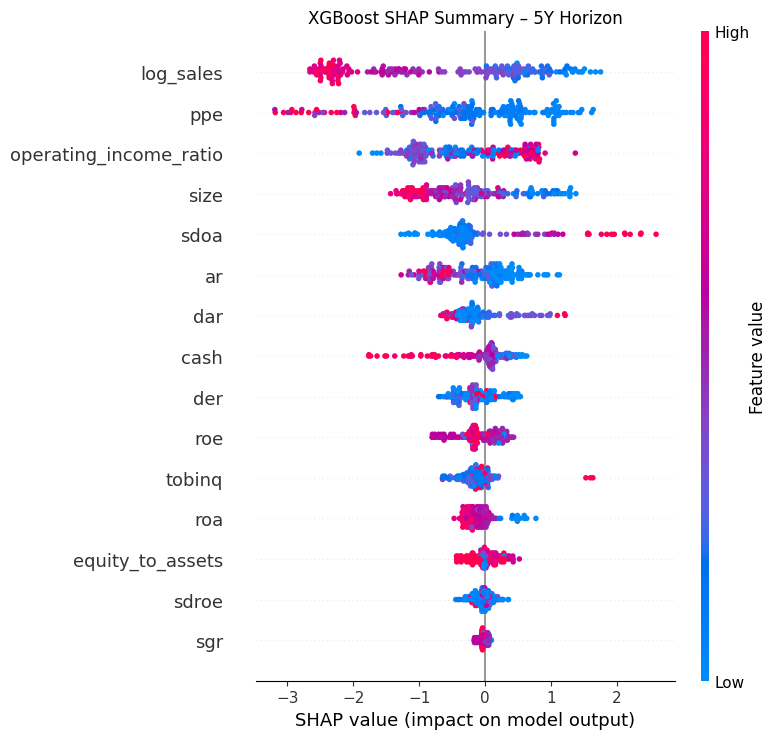

In [10]:
# ============================
# Evaluate and SHAP Plotting
# ============================

horizon_to_evaluate = 3
for h in [1, 2, 3, 4, 5]:
    evaluate_xgb_model(models[h])
    plot_shap_summary_for_horizon(models[h], feature_cols, model_type="xgb")

In [11]:
# ============================
# SHAP Feature Importance Bar Plot (Per Horizon)
# ============================

import shap
import matplotlib.pyplot as plt
import xgboost as xgb

def plot_shap_feature_importance(
    model,
    model_type,
    X_train,
    feature_cols,
    horizon=None,
    sample_n=200,
    background_n=100,
    random_state=42
):
    """
    SHAP feature importance (bar plot)

    - TreeExplainer : xgb, rf, lgbm
    - KernelExplainer : ngboost
    """

    # ============================
    # Sampling
    # ============================
    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=random_state
    )

    # ============================
    # TREE-BASED MODELS
    # ============================
    if model_type in ["xgb", "rf", "lgbm"]:

        if model_type == "xgb":
            dshap = xgb.DMatrix(X_sample, feature_names=feature_cols)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(dshap)

        else:
            explainer = shap.TreeExplainer(model)
            shap_values_raw = explainer.shap_values(X_sample)

            # binary classifier → ambil class 1
            if isinstance(shap_values_raw, list):
                shap_values = shap_values_raw[1]
            else:
                shap_values = shap_values_raw

    # ============================
    # NGBOOST (MODEL-AGNOSTIC)
    # ============================
    elif model_type == "ngboost":

        X_background = X_train.sample(
            n=min(background_n, len(X_train)),
            random_state=random_state
        )

        predict_fn = make_predict_fn(
            model=model,
            model_type="ngboost",
            feature_cols=feature_cols
        )

        explainer = shap.KernelExplainer(
            predict_fn,
            X_background,
            link="logit"
        )

        shap_values = explainer.shap_values(X_sample)

    else:
        raise ValueError(
            "model_type must be 'xgb', 'rf', 'lgbm', or 'ngboost'"
        )

    # ============================
    # Plot
    # ============================
    model_name = MODEL_TITLE_MAP.get(model_type, model_type.upper())

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_cols,
        plot_type="bar",
        show=False
    )

    title = f"SHAP Feature Importance {model_name}"
    if horizon is not None:
        title += f" - {horizon}Y Horizon"

    plt.title(title)
    plt.tight_layout()
    plt.show()

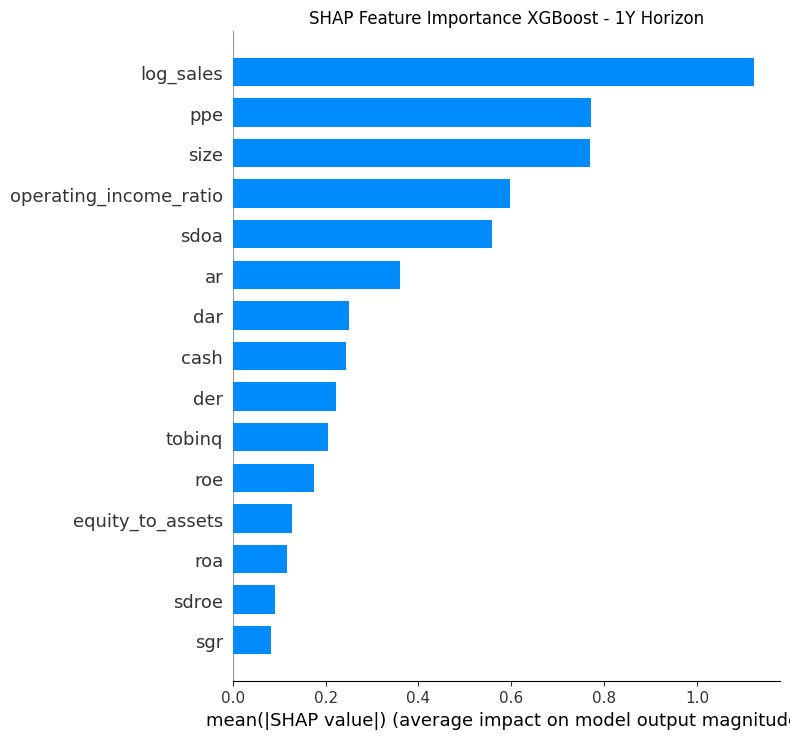

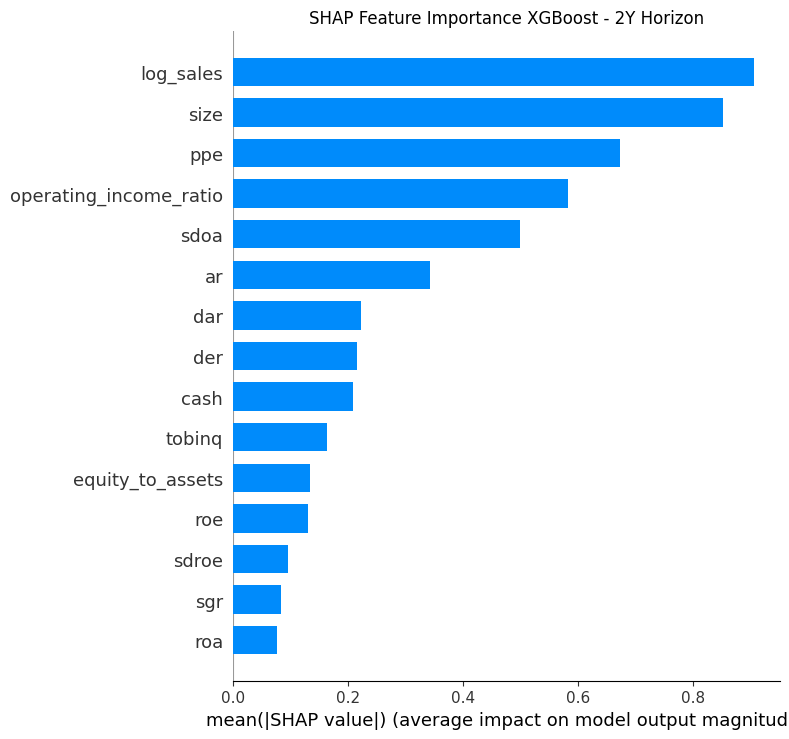

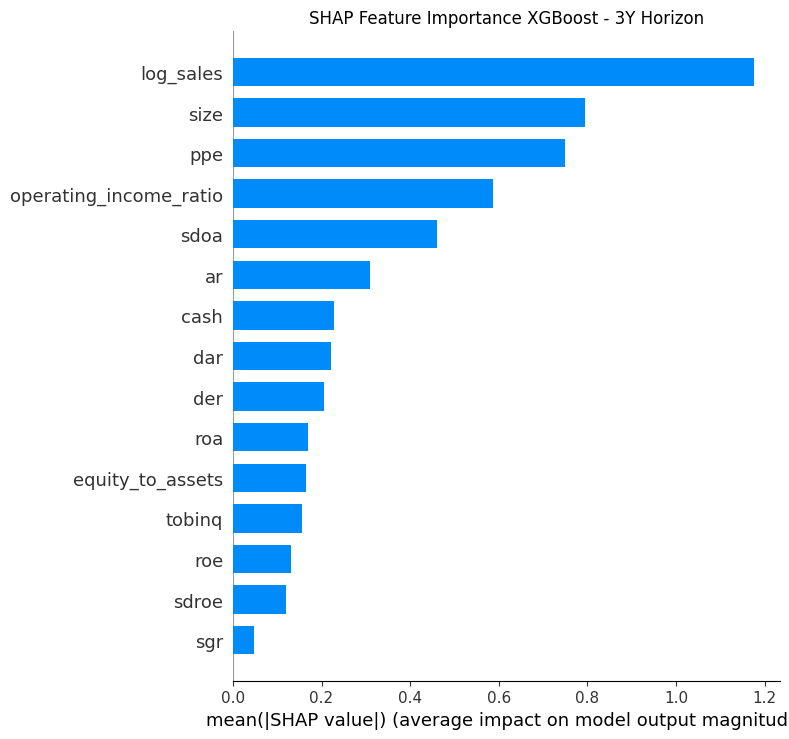

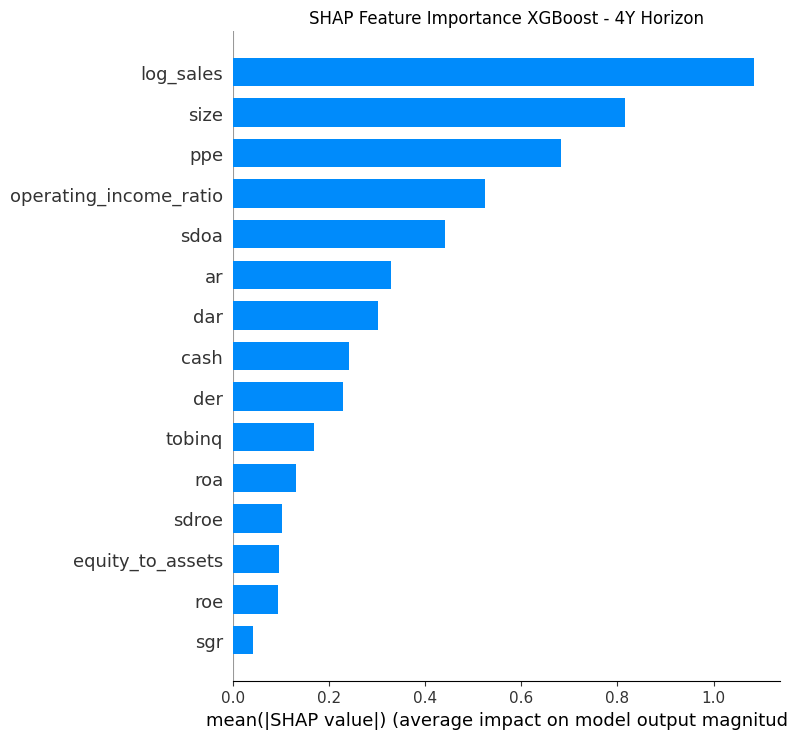

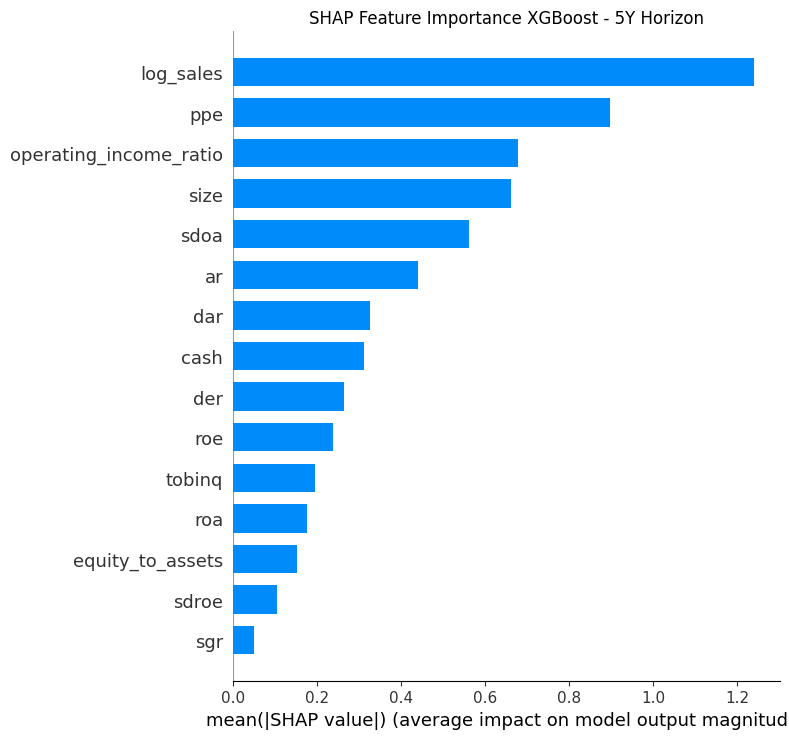

In [12]:
for h in [1, 2, 3, 4, 5]:
    plot_shap_feature_importance(
        model=models[h]["booster"],
        model_type="xgb",
        X_train=models[h]["X_train"],
        feature_cols=feature_cols,
        horizon=h
    )


SHAP Dependence – 1Y Horizon


<Figure size 640x480 with 0 Axes>

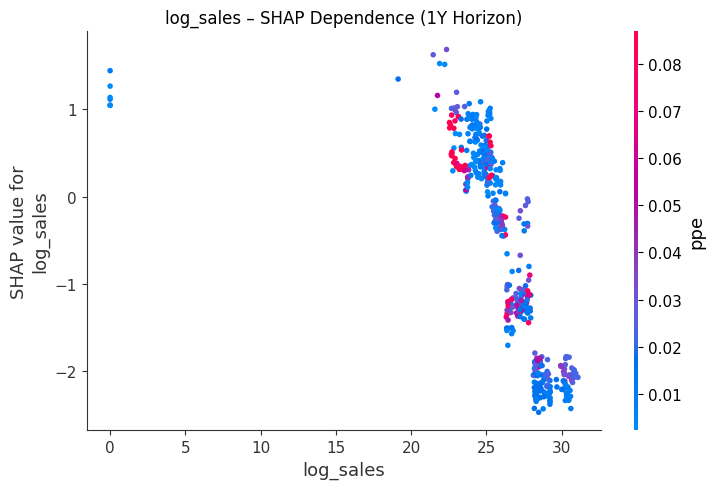

<Figure size 640x480 with 0 Axes>

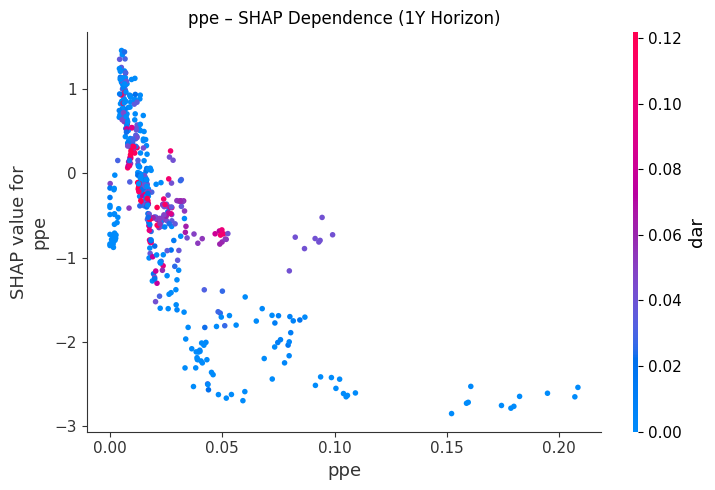

<Figure size 640x480 with 0 Axes>

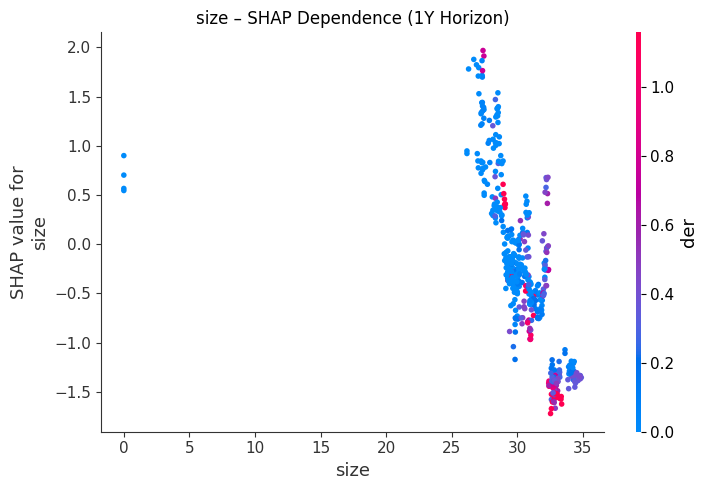

<Figure size 640x480 with 0 Axes>

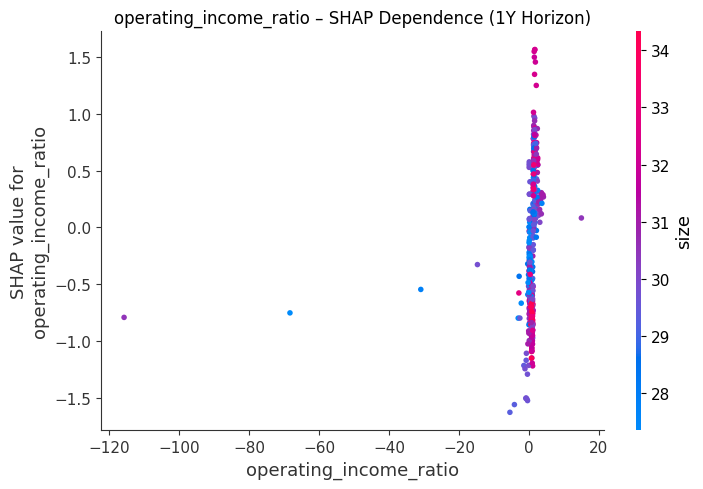

<Figure size 640x480 with 0 Axes>

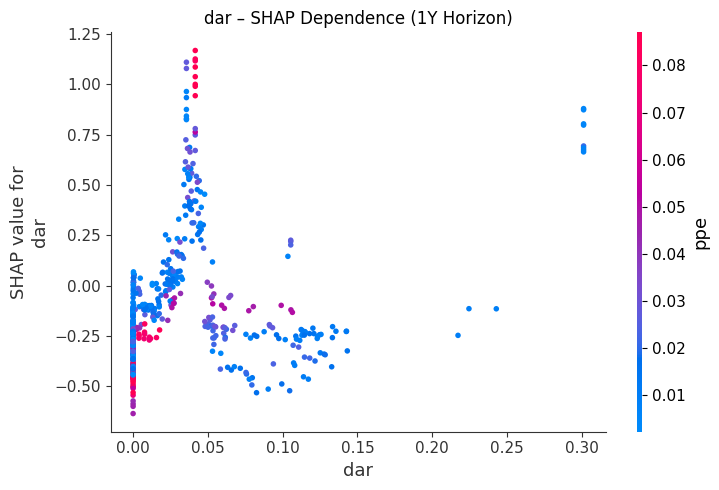

<Figure size 640x480 with 0 Axes>

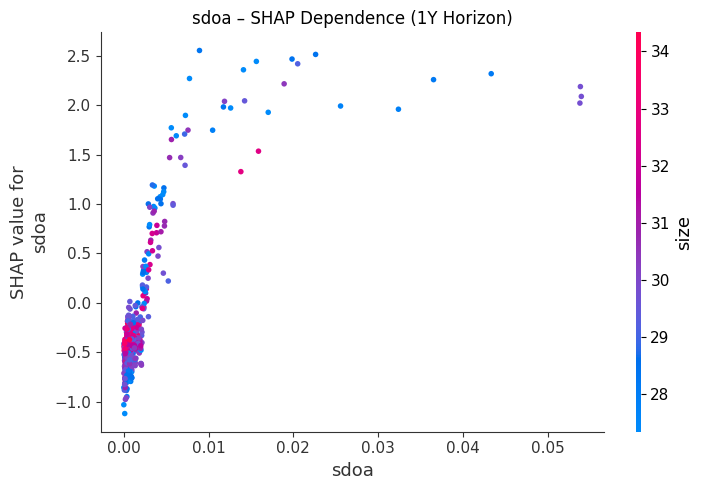


SHAP Dependence – 2Y Horizon


<Figure size 640x480 with 0 Axes>

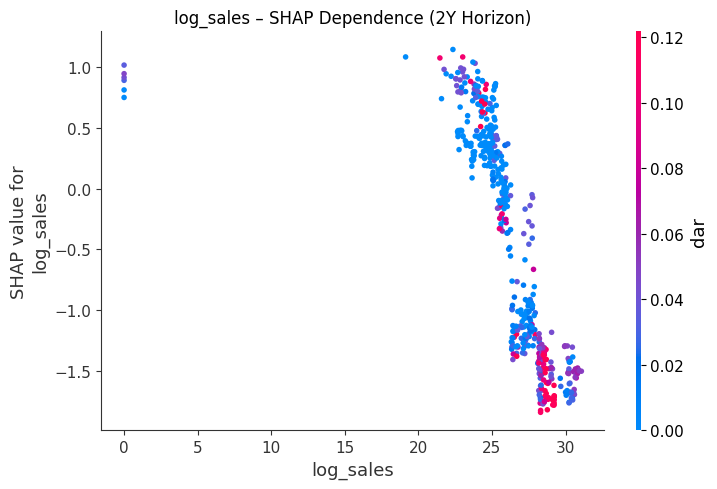

<Figure size 640x480 with 0 Axes>

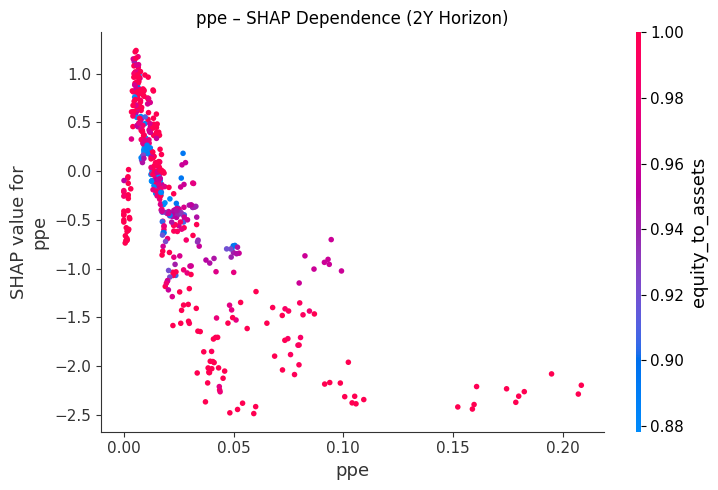

<Figure size 640x480 with 0 Axes>

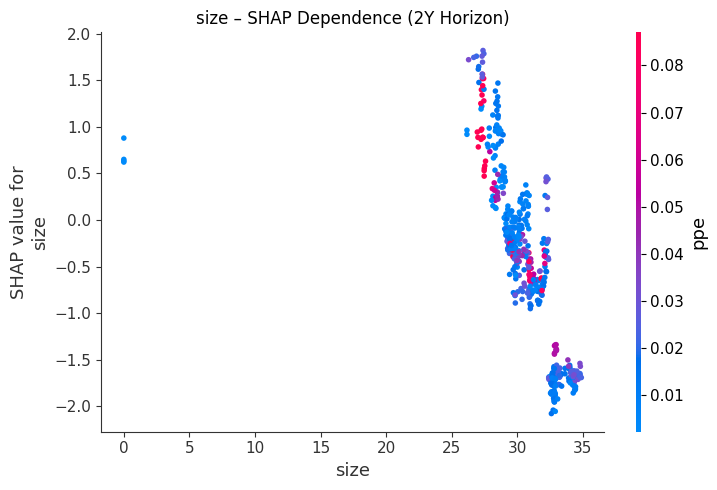

<Figure size 640x480 with 0 Axes>

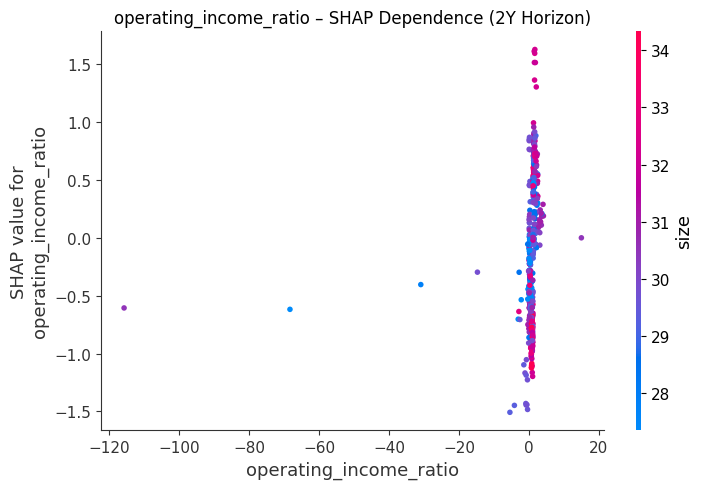

<Figure size 640x480 with 0 Axes>

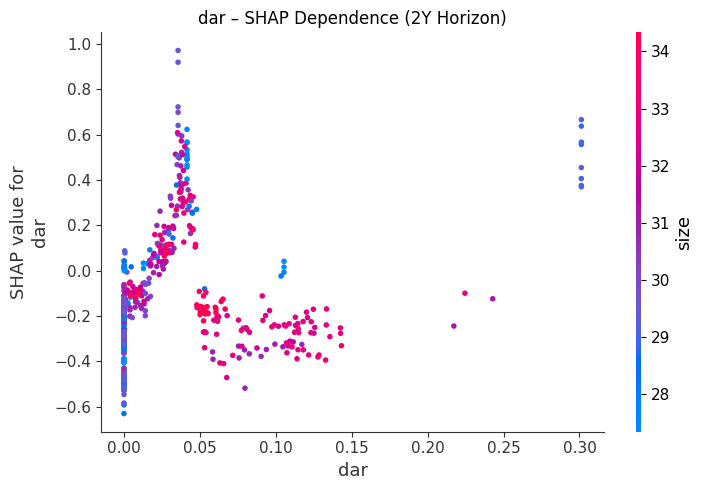

<Figure size 640x480 with 0 Axes>

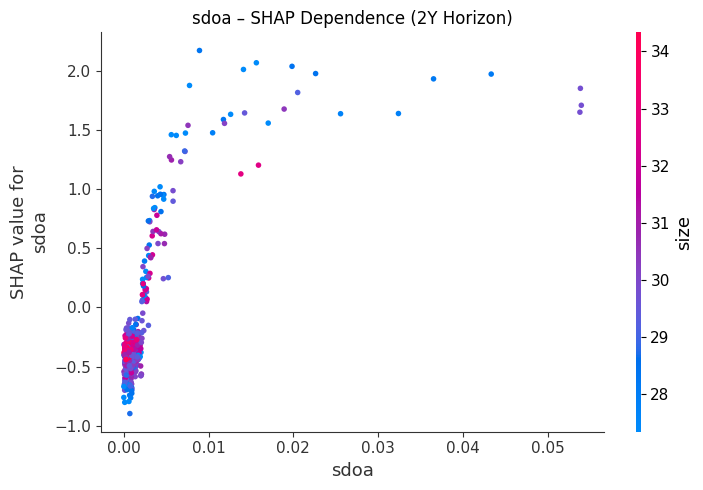


SHAP Dependence – 3Y Horizon


<Figure size 640x480 with 0 Axes>

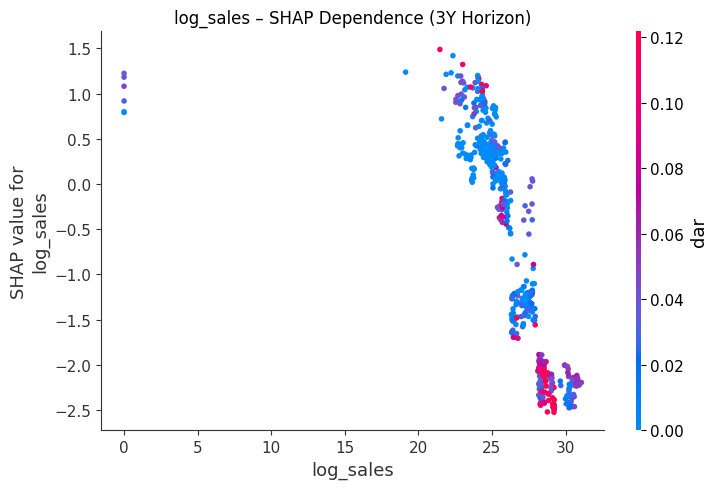

<Figure size 640x480 with 0 Axes>

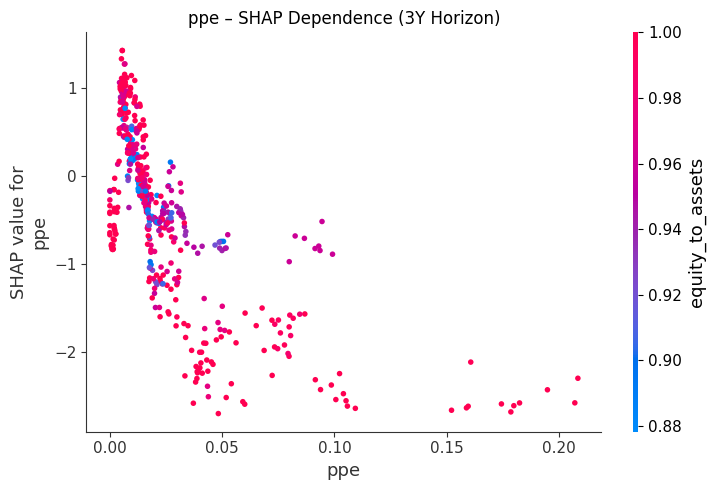

<Figure size 640x480 with 0 Axes>

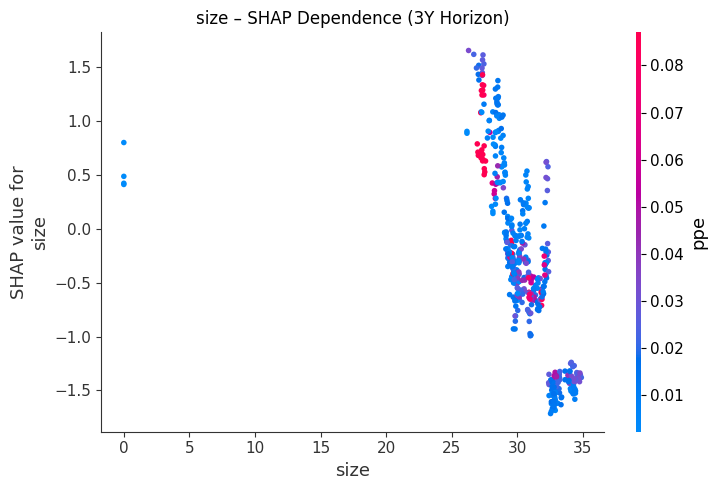

<Figure size 640x480 with 0 Axes>

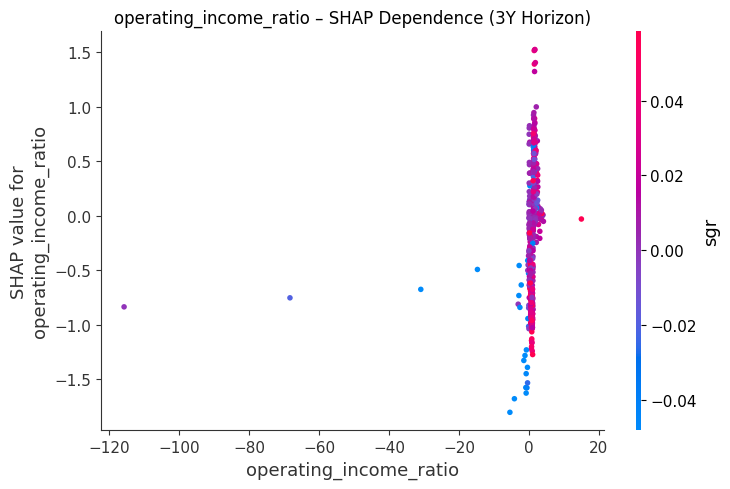

<Figure size 640x480 with 0 Axes>

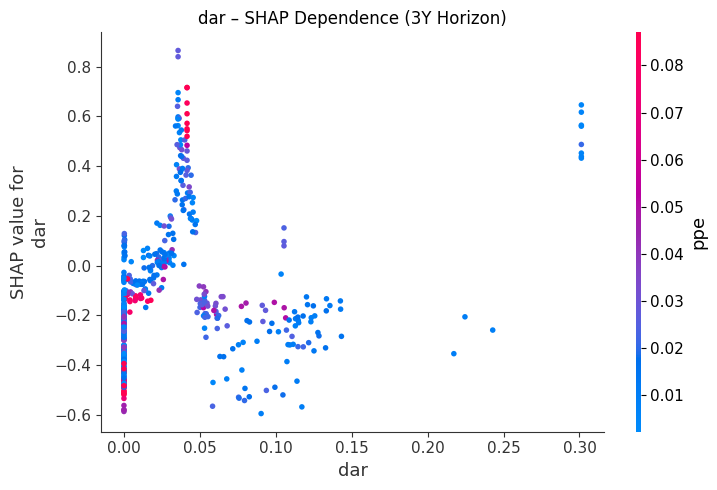

<Figure size 640x480 with 0 Axes>

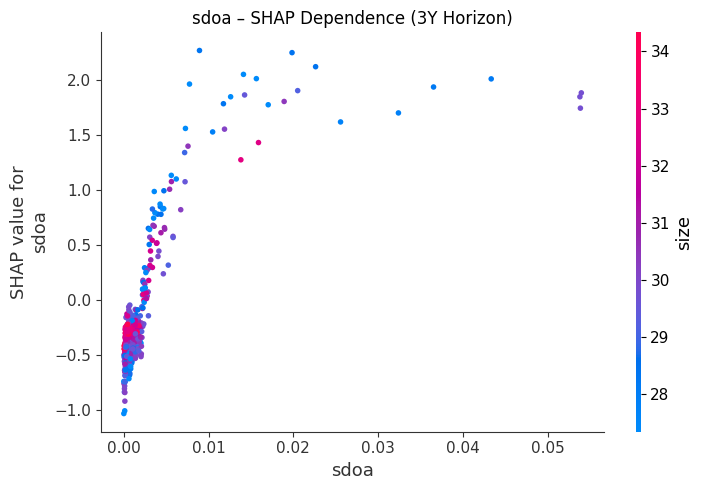


SHAP Dependence – 4Y Horizon


<Figure size 640x480 with 0 Axes>

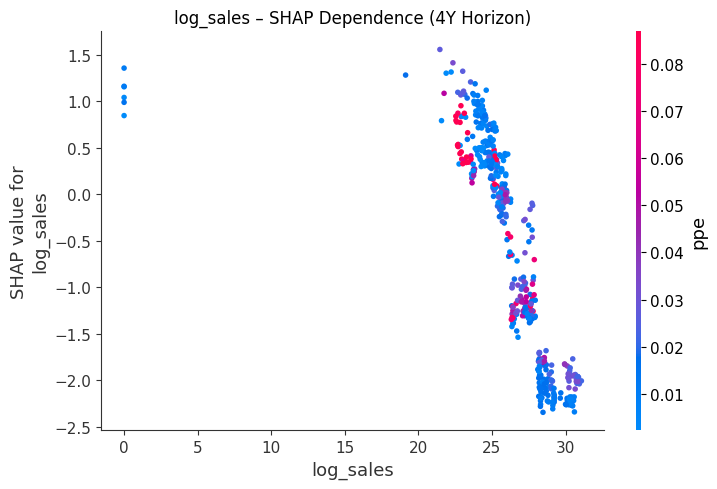

<Figure size 640x480 with 0 Axes>

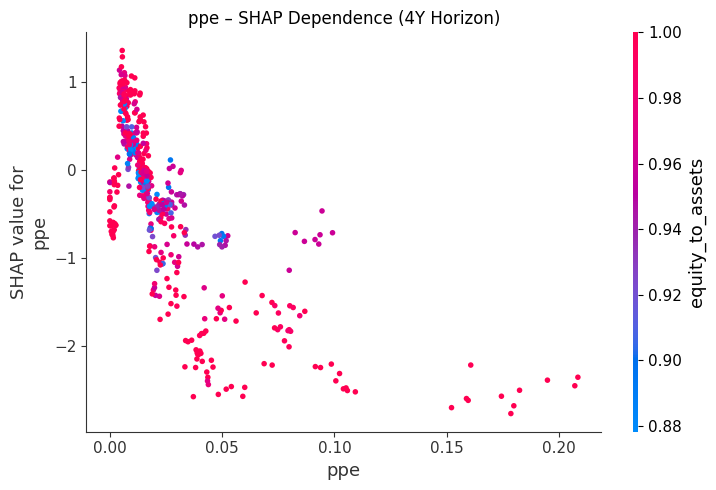

<Figure size 640x480 with 0 Axes>

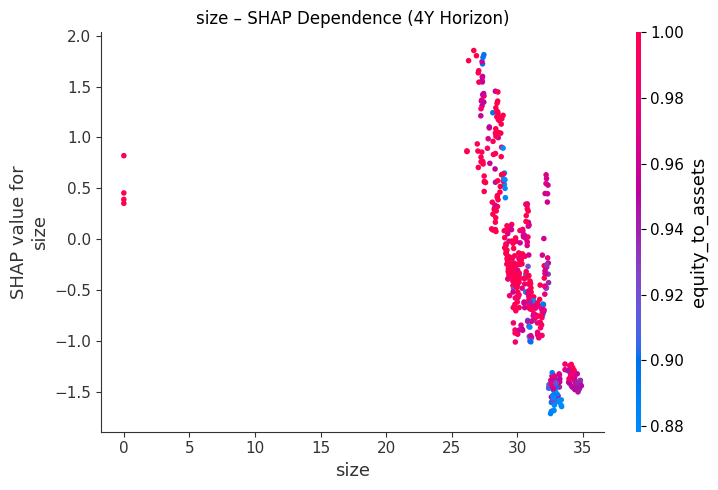

<Figure size 640x480 with 0 Axes>

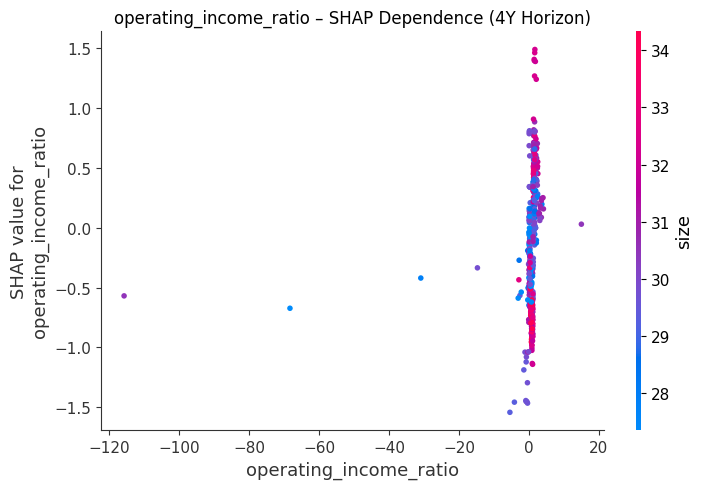

<Figure size 640x480 with 0 Axes>

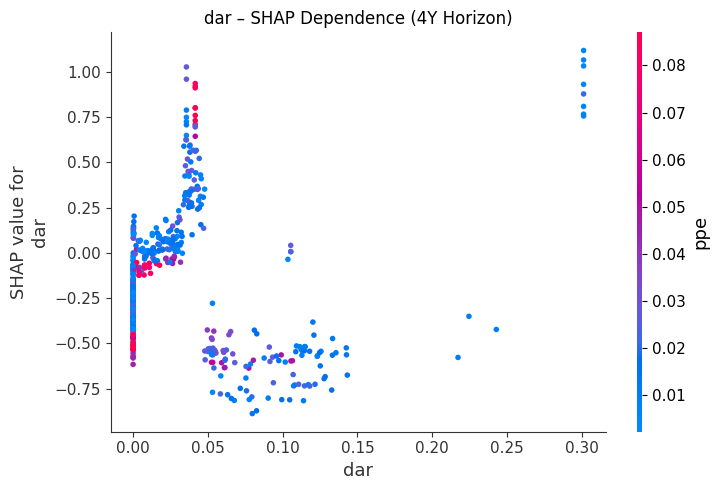

<Figure size 640x480 with 0 Axes>

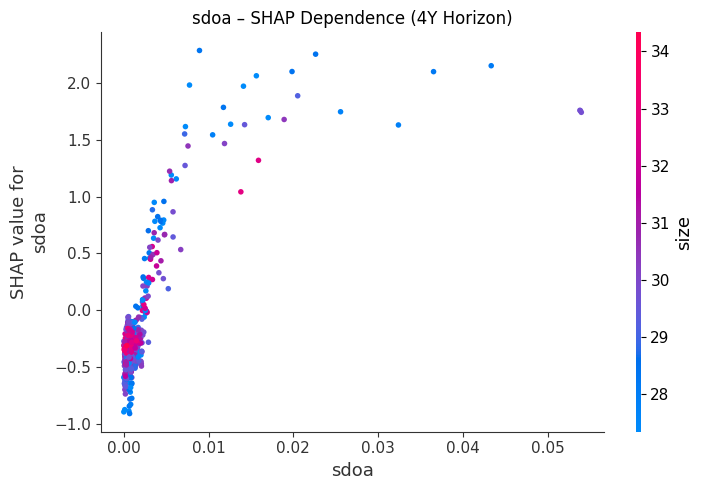


SHAP Dependence – 5Y Horizon


<Figure size 640x480 with 0 Axes>

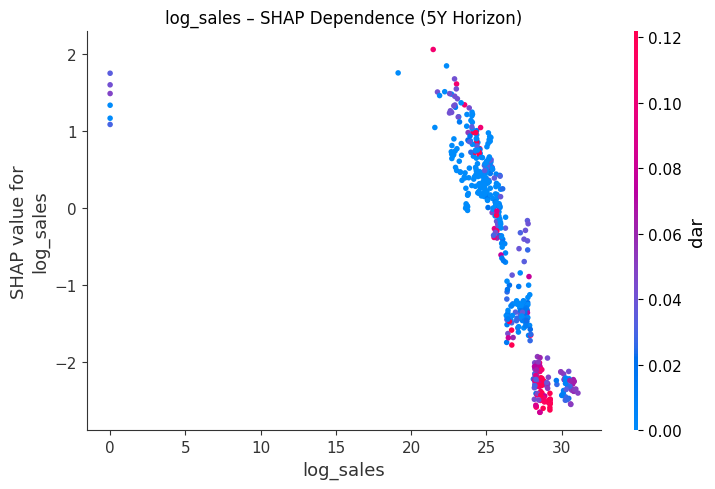

<Figure size 640x480 with 0 Axes>

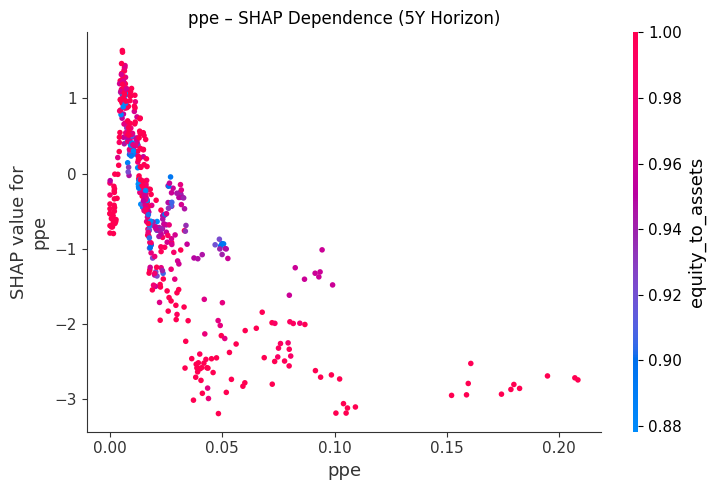

<Figure size 640x480 with 0 Axes>

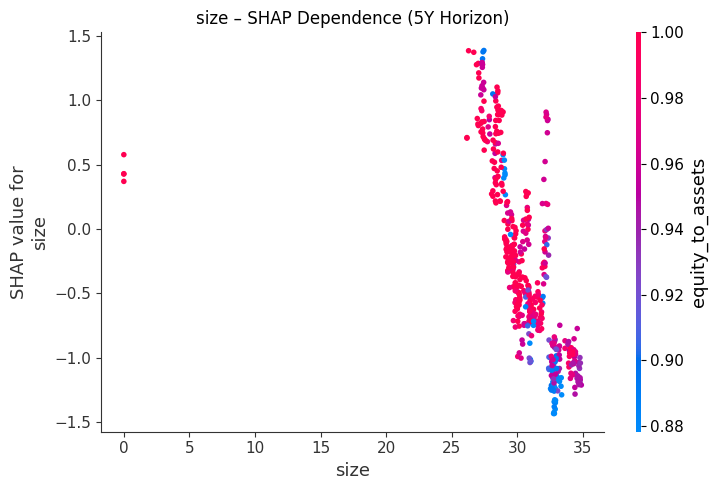

<Figure size 640x480 with 0 Axes>

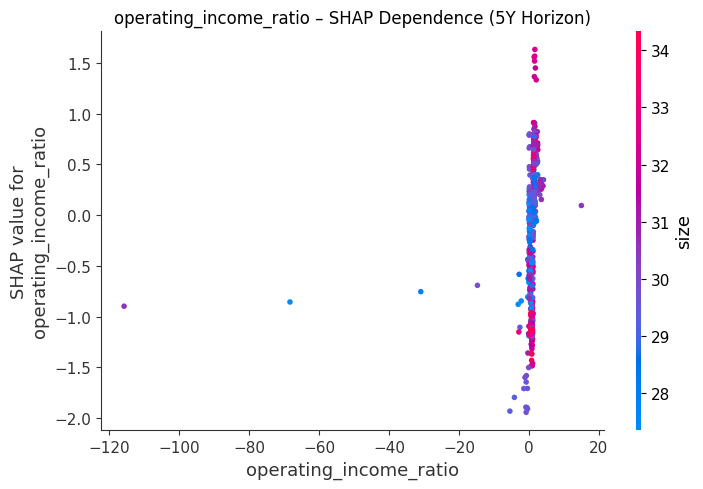

<Figure size 640x480 with 0 Axes>

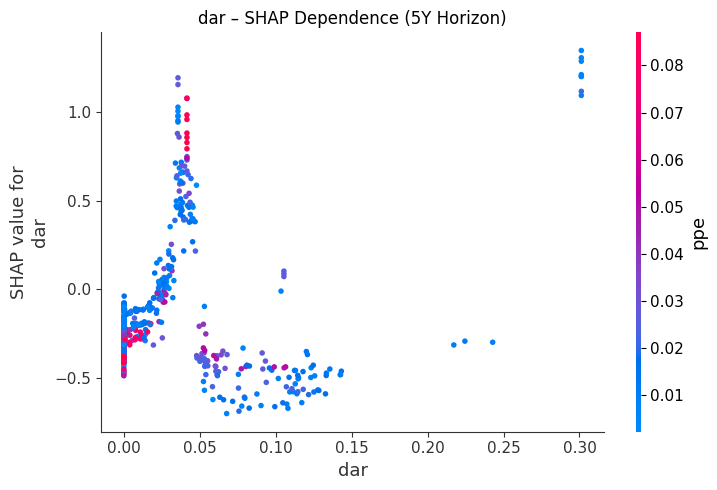

<Figure size 640x480 with 0 Axes>

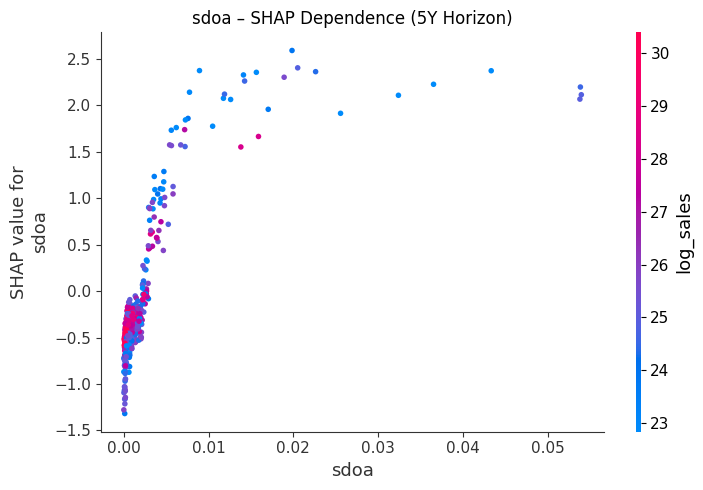

In [13]:
# ============================
# SHAP Dependence Plot (Per Horizon)
# ============================

import shap
import xgboost as xgb
import matplotlib.pyplot as plt

top_features = [
    "log_sales",
    "ppe",
    "size",
    "operating_income_ratio",
    "dar",
    "sdoa",
]

for h in [1, 2, 3, 4, 5]:
    print(f"\nSHAP Dependence – {h}Y Horizon")

    booster = models[h]["booster"]
    X_train_h = models[h]["X_train"]

    # sampling (penting agar cepat & stabil)
    X_shap = X_train_h.sample(
        n=min(500, len(X_train_h)),
        random_state=42
    )

    dshap = xgb.DMatrix(X_shap)

    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(dshap)

    for feat in top_features:
        if feat not in X_shap.columns:
            continue

        plt.figure()
        shap.dependence_plot(
            feat,
            shap_values,
            X_shap,
            show=False
        )
        plt.title(f"{feat} – SHAP Dependence ({h}Y Horizon)")
        plt.tight_layout()
        plt.show()
